## XGBModel (Extreme Gradient Boosting)
- Multivariate
- It provides prallel tree boosting and is a machine learning library for regression, clasification and ranking problems.


In [2]:
from darts import TimeSeries
from darts.models import XGBModel
from darts.utils.statistics import plot_hist
from darts.metrics import mape
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')

In [4]:
df = df.drop(['date', 'day_of_week', 'time', 'month'], axis=1)

In [6]:
df.head(3)

,datetime,wind_speed,solar_radiation,temperature,nuclear_power,not_renewable,renewable,energy_price,total_energy_feeding
0,2020-01-01 00:00:00,2.4,0,-0.1,8088.21750,29512.74850,14541.30200,38.60,52142.26800
1,2020-01-01 01:00:00,2.4,0,-0.5,8081.15875,29178.66275,14949.45575,36.55,52209.27725
2,2020-01-01 02:00:00,2.5,0,-0.7,8071.44750,29414.36225,15077.92500,32.32,52563.73475


In [9]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df,
                                   time_col="datetime", 
                                   value_cols=['wind_speed', 'solar_radiation', 'temperature', 'nuclear_power', 'not_renewable', 'renewable', 'energy_price'])

splitting_point = (int(len(series)*0.20))

# Set aside the second half of series as a validation series
train, val = series[:-splitting_point], series[-splitting_point:]
# train, val = series.split_before(0.75)

In [10]:
model = XGBModel(lags=168)

In [11]:
model.fit(train)
forecast = model.predict(len(val))
print(f'model {model} obtains MAPE: {mape(val, forecast):.2f}%')

ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

## Historical forecasts
Forecasting using historical data.

*Backtesting: General method for seeing how well a model would have done using historical data.

In [ ]:
historical_fcast = model.historical_forecasts(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    overlap_end=False,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

MAPE = 99.54%


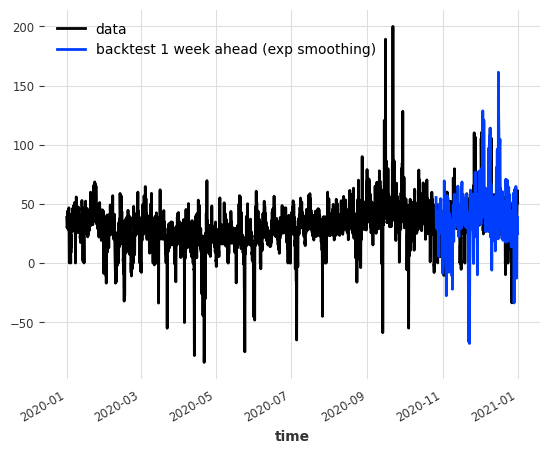

In [ ]:
series.plot(label='data')
historical_fcast.plot(label='backtest 1 week ahead (exp smoothing)')
print(f'MAPE = {mape(historical_fcast, series):.2f}%')

## Backtest
It repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

In [ ]:
raw_errors = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=None,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

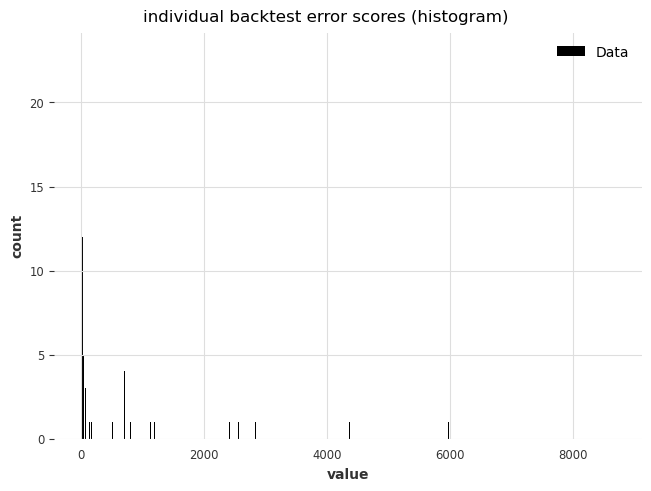

In [ ]:
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title='individual backtest error scores (histogram)'
)

In [ ]:
median_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=np.median,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

In [ ]:
print(f'Median error (MAPE) over all historical forecasts: {median_error:.2f}%')

Median error (MAPE) over all historical forecasts: 71.43%


In [ ]:
average_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=np.mean,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

In [ ]:
print(f'Average error (MAPE) over all historical forecasts: {average_error:.2f}%')

Average error (MAPE) over all historical forecasts: 1033.33%
